In [1]:
import numpy as np
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator
from landlab import imshow_grid
from landlab.components.flexure import Flexure
from matplotlib import pyplot as plt

In [2]:
number_of_rows = 200            # number of raster cells in vertical direction (y)
number_of_columns = 200        # number of raster cells in horizontal direction (x)
dxy = 100                        # side length of a raster model cell, or resolution [m]

In [3]:
# Topographic Grid
mg = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Flexure grid
lith_press = mg.add_zeros("lithosphere__overlying_pressure_increment", at="node")
flex = Flexure(mg)

# Create random noise
np.random.seed(0)                                       # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000.     # intial noise on elevation grid

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise

In [4]:
# Define Boundary Conditions
East = 1
North = 1
West = 1
South = 1

mg.set_status_at_node_on_edges(right=East, top=North, left=West, bottom=South)

In [5]:
# Define Uplift Distribution 

# Initial uplift rate
U = 1E-3 # m/yr
uplift_rate = np.ones(mg.number_of_nodes)*U

# # One-time uplift event
# fault_location = 0  # [m] (original value = 4000)
# uplift_amount = 20 # [m] (original value = 10)
# zr[np.where(mg.node_y>fault_location)] += uplift_amount

## Continuously-slipping fault,
fault_location = 10000  # [m] (Original value = 4000)
low_uplift_rate = 1E-3 # [m/yr] (Original value = 0.0001)
high_uplift_rate = 1E-2 # [m/yr] (Original value = 0.0004)
uplift_rate[np.where(mg.node_y<fault_location)] = low_uplift_rate
uplift_rate[np.where(mg.node_y>fault_location)] = high_uplift_rate

# # Uplift Gradient
# low_uplift_rate = 0.0001 # [m/yr]
# high_uplift_rate = 0.004 # [m/yr]
# uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
# uplift_rate = low_uplift_rate + ((mg.node_y / dxy)-1) * uplift_rate_gradient

In [6]:
min_drainage_area = 1000
Edge = 1000
K_hs = 1E-3
K_sp1 = 1E-4                # erodibility in lower part/uniform
K_sp2 = 5E-4                # erodibility in upper part
m_sp = 0.5                  # exponent on drainage area in stream power equation
n_sp = 1                    # exponent on slope in stream power equation

#Define Spatial Erodibility
K_flag = True
if K_flag:
    K_sp = K_sp1
else:
    K_sp = np.ones(mg.number_of_nodes)
    K_sp[np.where(mg.node_y<=Edge)] = K_sp1
    K_sp[np.where(mg.node_y>=Edge)] = K_sp2
    
print(K_sp)

0.0001


In [7]:
frr = FlowAccumulator(mg)
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)
dfn = LinearDiffuser(mg, linear_diffusivity=K_hs, deposit = False)

In [8]:
dt = 1000           # time step [yr]
tmax = 1E5        # time for the model loop to run [yr]
total_time = 0
t = np.arange(0, tmax, dt)

In [9]:
for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt  # uplift the landscape
    dfn.run_one_step(dt)                                # diffuse the landscape
    frr.run_one_step()                                  # route flow
    spr.run_one_step(dt)                                # fluvial incision
    total_time += dt                                    # update time keeper
   # print(total_time)

C:\Users\97205\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:266: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(color=color_for_closed)
C:\Users\97205\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:306: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


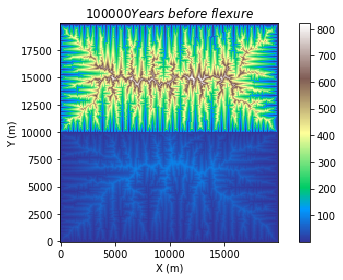

820.07782083


In [10]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = str(total_time)+'$Years$ $before$ $flexure$'
plt.title(title_text)
plt.tight_layout()
plt.show()

print(zr.max())

31.8596536731


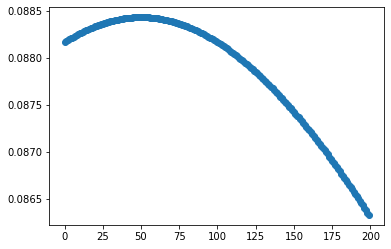

1.68773E+10
0.0897126590669


In [11]:
# Calculate flexure load
loads = mg.add_zeros('node', 'load')
dz_flex = mg.add_zeros('node', 'deflection')
rho_s = 2700  # rock density (kg/m^3)
g = 9.81  # gravity constant (m/s^2)
L = 20000 # half plate length (m)
# h = 1000  # sediment fill thickness (m)
h = zr[mg.node_y<fault_location].mean()  # sediment fill thickness (m)
print(h)

load = rho_s*9.81*h*L  # effective load (N)
loads[10000] = load

# Calculate deflection
dz_flex = flex.subside_loads(loads, out=None)
dz_flex = dz_flex.flatten()

# update topography
zr -= dz_flex

# Plot deflection transect along middle Y axis
tt = np.where(mg.node_x==10000)
plt.plot(dz_flex[tt], 'o')

plt.show()

print('{:.5E}'.format(load))
print(dz_flex.max())

C:\Users\97205\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:266: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(color=color_for_closed)
C:\Users\97205\anaconda3\envs\espin\lib\site-packages\landlab\plot\imshow.py:306: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


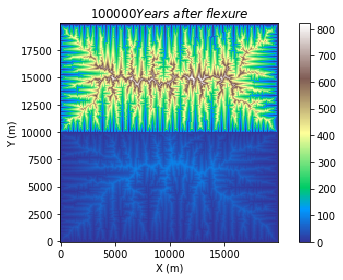

819.99082888


In [12]:
imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'), cmap='terrain', allow_colorbar=True)
title_text = str(total_time)+'$Years$ $after$ $flexure$'
plt.title(title_text)
plt.tight_layout()
plt.show()

print(zr.max())